In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression  #1
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier     #2
from sklearn.svm import SVC

from catboost import CatBoostClassifier       #3
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import warnings
warnings.simplefilter(action="ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 170)
# pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [5]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv", delimiter = ';')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.65,Yes


In [6]:
df.shape

(7043, 21)

In [7]:
df = df.drop(["customerID"], axis=1)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [9]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [10]:
df["Churn"] = df["Churn"].apply(lambda x : 1 if x == "Yes" else 0)

In [11]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.850,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.500,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.150,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.750,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.650,1


In [12]:
df.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [13]:
summary = df.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T
summary.head()


,0.000,0.050,0.500,0.950,0.990,1.000
SeniorCitizen,0.000,0.000,0.000,1.000,1.000,1.000
tenure,0.000,1.000,29.000,72.000,72.000,72.000
MonthlyCharges,18.250,19.650,70.350,107.400,114.729,118.750
TotalCharges,18.800,49.605,1397.475,6923.590,8039.883,8684.800
Churn,0.000,0.000,0.000,1.000,1.000,1.000


In [14]:
cat_cols = [col for col in df.columns if df[col].dtypes == "O"]

In [15]:
cat_cols

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [16]:
cat_cols

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [17]:
num_cols = [col for col in df.columns if df[col].dtypes != "O"]

In [18]:
num_cols

['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']

        gender  Ratio
Male      3555 50.476
Female    3488 49.524


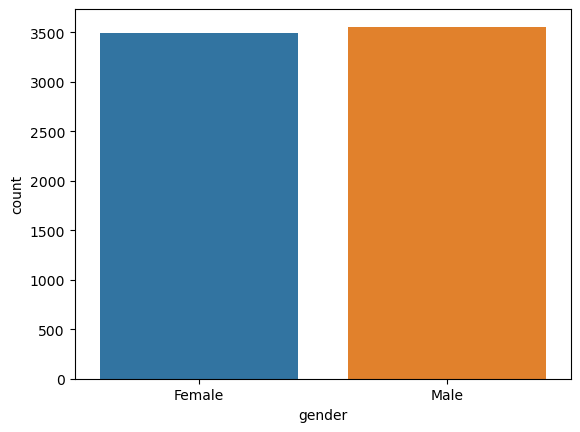

     Partner  Ratio
No      3641 51.697
Yes     3402 48.303


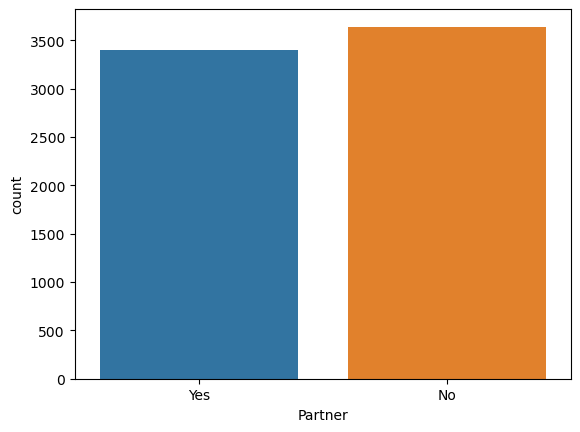

     Dependents  Ratio
No         4933 70.041
Yes        2110 29.959


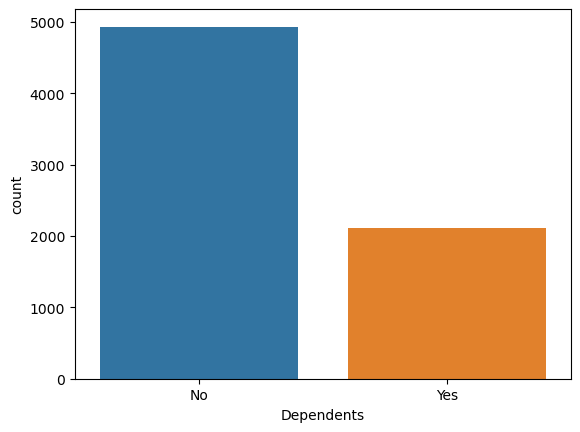

     PhoneService  Ratio
Yes          6361 90.317
No            682  9.683


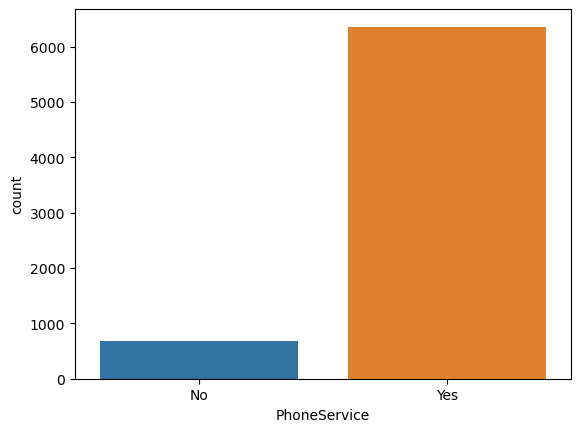

                  MultipleLines  Ratio
No                         3390 48.133
Yes                        2971 42.184
No phone service            682  9.683


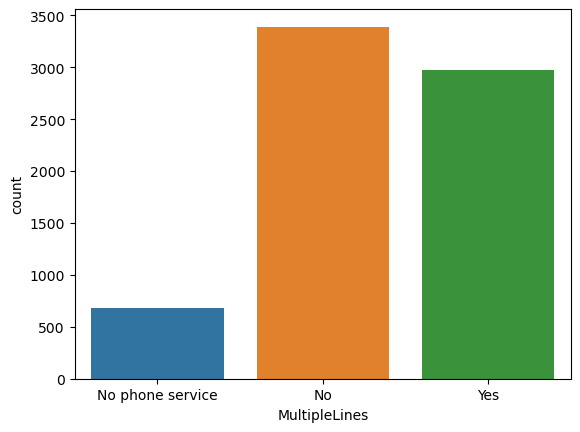

             InternetService  Ratio
Fiber optic             3096 43.959
DSL                     2421 34.375
No                      1526 21.667


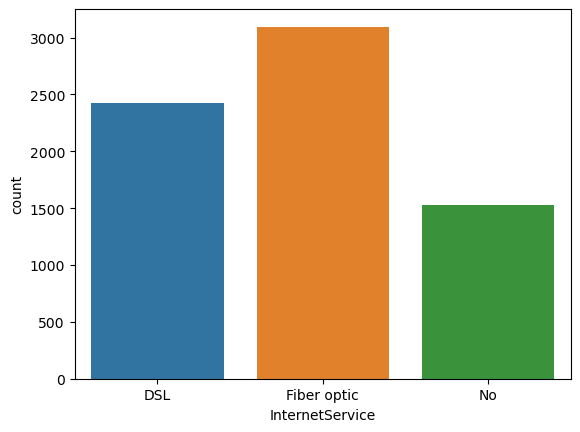

                     OnlineSecurity  Ratio
No                             3498 49.666
Yes                            2019 28.667
No internet service            1526 21.667


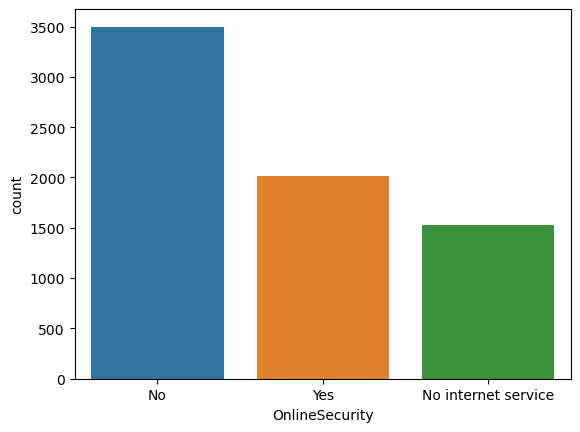

                     OnlineBackup  Ratio
No                           3088 43.845
Yes                          2429 34.488
No internet service          1526 21.667


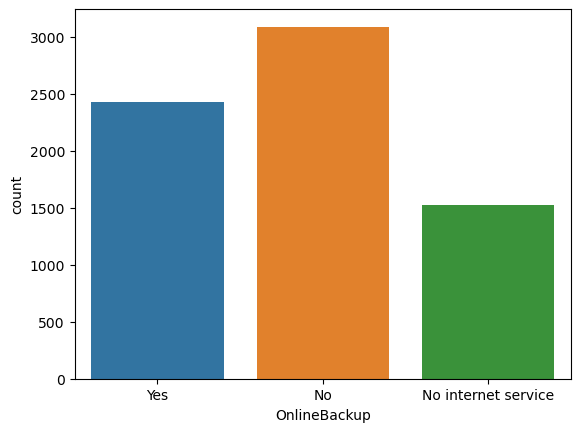

                     DeviceProtection  Ratio
No                               3095 43.944
Yes                              2422 34.389
No internet service              1526 21.667


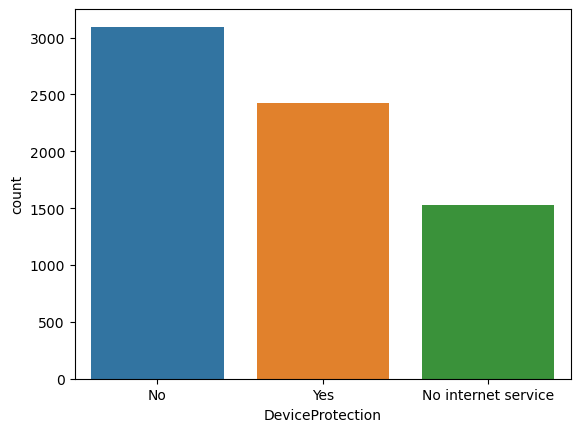

                     TechSupport  Ratio
No                          3473 49.311
Yes                         2044 29.022
No internet service         1526 21.667


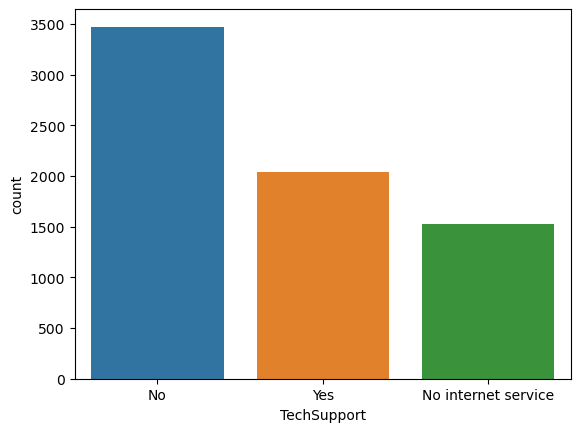

                     StreamingTV  Ratio
No                          2810 39.898
Yes                         2707 38.435
No internet service         1526 21.667


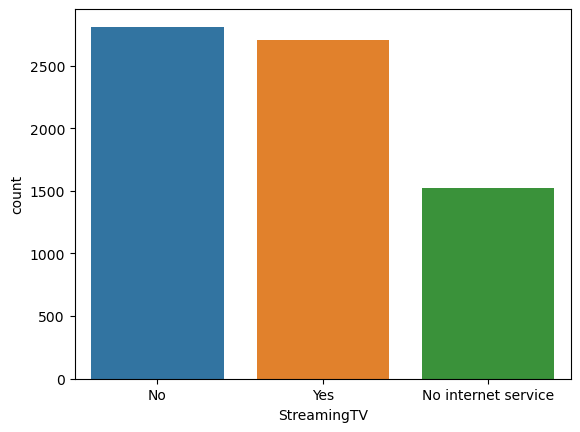

                     StreamingMovies  Ratio
No                              2785 39.543
Yes                             2732 38.790
No internet service             1526 21.667


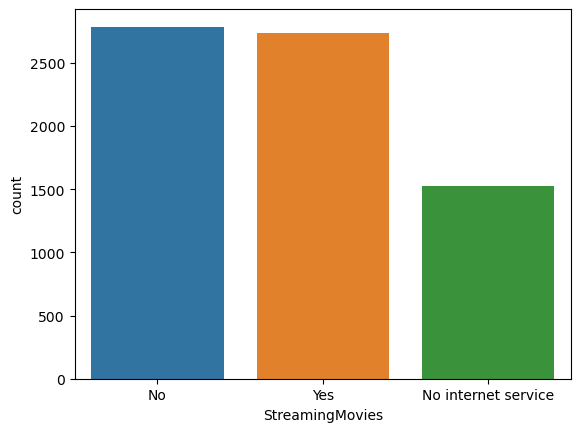

                Contract  Ratio
Month-to-month      3875 55.019
Two year            1695 24.066
One year            1473 20.914


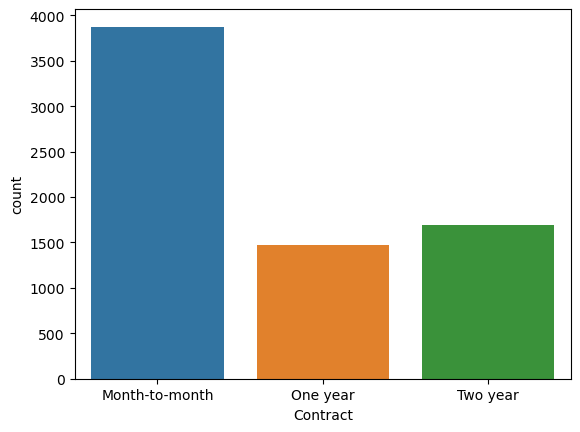

     PaperlessBilling  Ratio
Yes              4171 59.222
No               2872 40.778


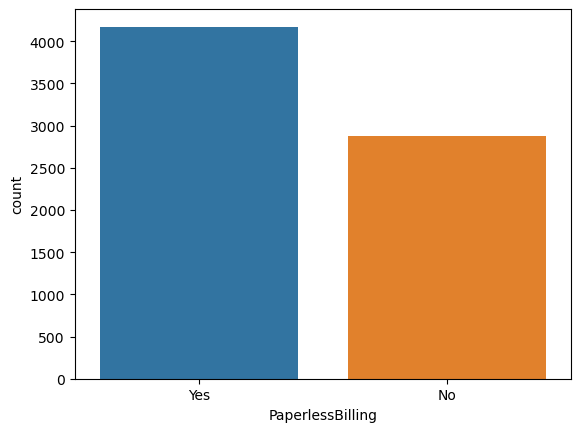

                           PaymentMethod  Ratio
Electronic check                    2365 33.579
Mailed check                        1612 22.888
Bank transfer (automatic)           1544 21.922
Credit card (automatic)             1522 21.610


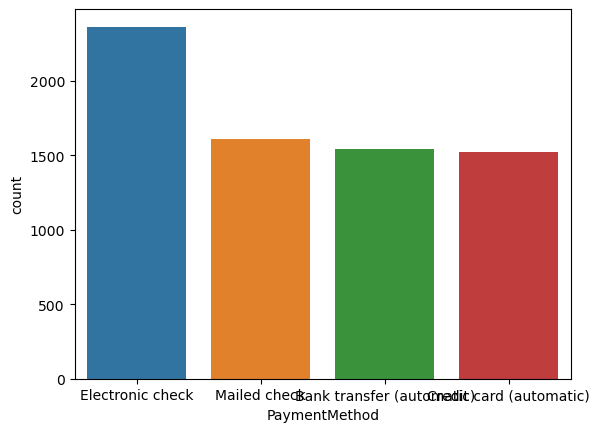

In [19]:
for col in cat_cols:
        print(pd.DataFrame({col: df[col].value_counts(),
                        "Ratio": 100 * df[col].value_counts() / len(df)}))
        sns.countplot(x=df[col], data=df)
        plt.show()

In [20]:
num_cols

['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']

count   7043.000
mean       0.162
std        0.369
min        0.000
1%         0.000
5%         0.000
25%        0.000
50%        0.000
75%        0.000
95%        1.000
99%        1.000
max        1.000
Name: SeniorCitizen, dtype: float64


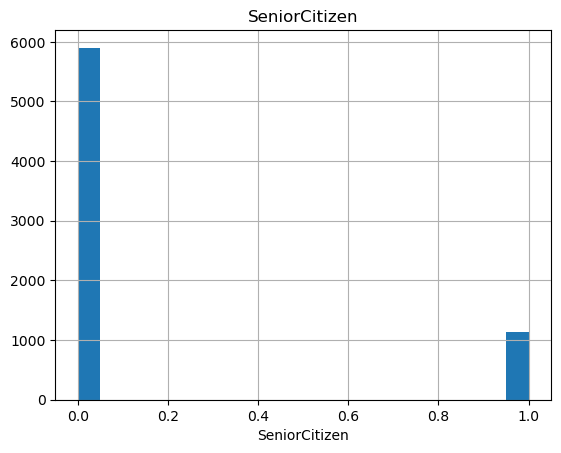

count   7043.000
mean      32.371
std       24.559
min        0.000
1%         1.000
5%         1.000
25%        9.000
50%       29.000
75%       55.000
95%       72.000
99%       72.000
max       72.000
Name: tenure, dtype: float64


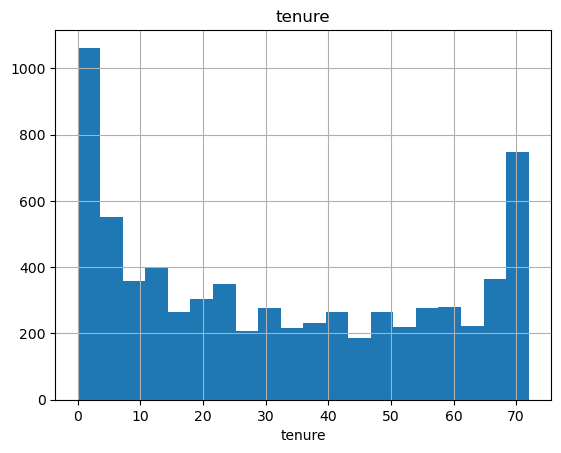

count   7043.000
mean      64.762
std       30.090
min       18.250
1%        19.200
5%        19.650
25%       35.500
50%       70.350
75%       89.850
95%      107.400
99%      114.729
max      118.750
Name: MonthlyCharges, dtype: float64


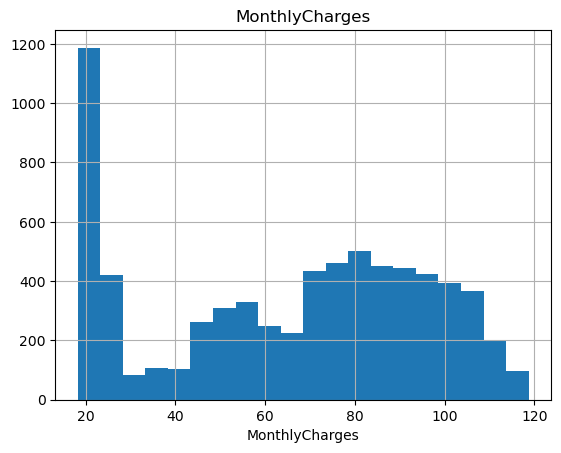

count   7032.000
mean    2283.300
std     2266.771
min       18.800
1%        19.900
5%        49.605
25%      401.450
50%     1397.475
75%     3794.738
95%     6923.590
99%     8039.883
max     8684.800
Name: TotalCharges, dtype: float64


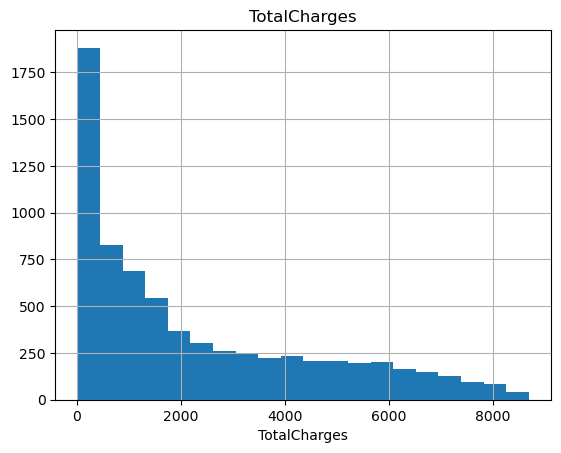

count   7043.000
mean       0.265
std        0.442
min        0.000
1%         0.000
5%         0.000
25%        0.000
50%        0.000
75%        1.000
95%        1.000
99%        1.000
max        1.000
Name: Churn, dtype: float64


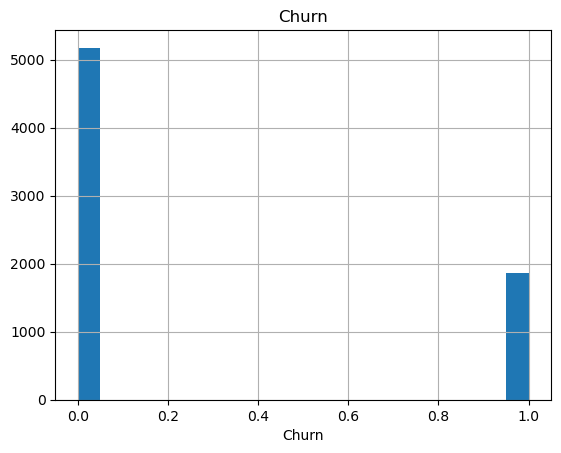

In [21]:
quantiles = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]
for col in num_cols:
    print(df[col].describe(quantiles).T)
    
    df[col].hist(bins=20)
    plt.xlabel(col)
    plt.title(col)
    plt.show()

In [22]:
for col in num_cols:
    print(df.groupby("Churn").agg({col: "mean"}), end="\n\n\n")

       SeniorCitizen
Churn               
0              0.129
1              0.255


       tenure
Churn        
0      37.570
1      17.979


       MonthlyCharges
Churn                
0              61.265
1              74.441


       TotalCharges
Churn              
0          2555.344
1          1531.796


       Churn
Churn       
0      0.000
1      1.000




In [23]:
for col in cat_cols:
    print(col)
    print(pd.DataFrame({"TARGET_MEAN": df.groupby(col)["Churn"].mean(),
                        "Count": df[col].value_counts(),
                        "Ratio": 100 * df[col].value_counts() / len(df)}), end="\n\n\n")


gender
        TARGET_MEAN  Count  Ratio
Female        0.269   3488 49.524
Male          0.262   3555 50.476


Partner
     TARGET_MEAN  Count  Ratio
No         0.330   3641 51.697
Yes        0.197   3402 48.303


Dependents
     TARGET_MEAN  Count  Ratio
No         0.313   4933 70.041
Yes        0.155   2110 29.959


PhoneService
     TARGET_MEAN  Count  Ratio
No         0.249    682  9.683
Yes        0.267   6361 90.317


MultipleLines
                  TARGET_MEAN  Count  Ratio
No                      0.250   3390 48.133
No phone service        0.249    682  9.683
Yes                     0.286   2971 42.184


InternetService
             TARGET_MEAN  Count  Ratio
DSL                0.190   2421 34.375
Fiber optic        0.419   3096 43.959
No                 0.074   1526 21.667


OnlineSecurity
                     TARGET_MEAN  Count  Ratio
No                         0.418   3498 49.666
No internet service        0.074   1526 21.667
Yes                        0.146   2019 28.667


O

In [24]:
df[num_cols].corr()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
SeniorCitizen,1.000,0.017,0.220,0.102,0.151
tenure,0.017,1.000,0.248,0.826,-0.352
MonthlyCharges,0.220,0.248,1.000,0.651,0.193
TotalCharges,0.102,0.826,0.651,1.000,-0.199
Churn,0.151,-0.352,0.193,-0.199,1.000


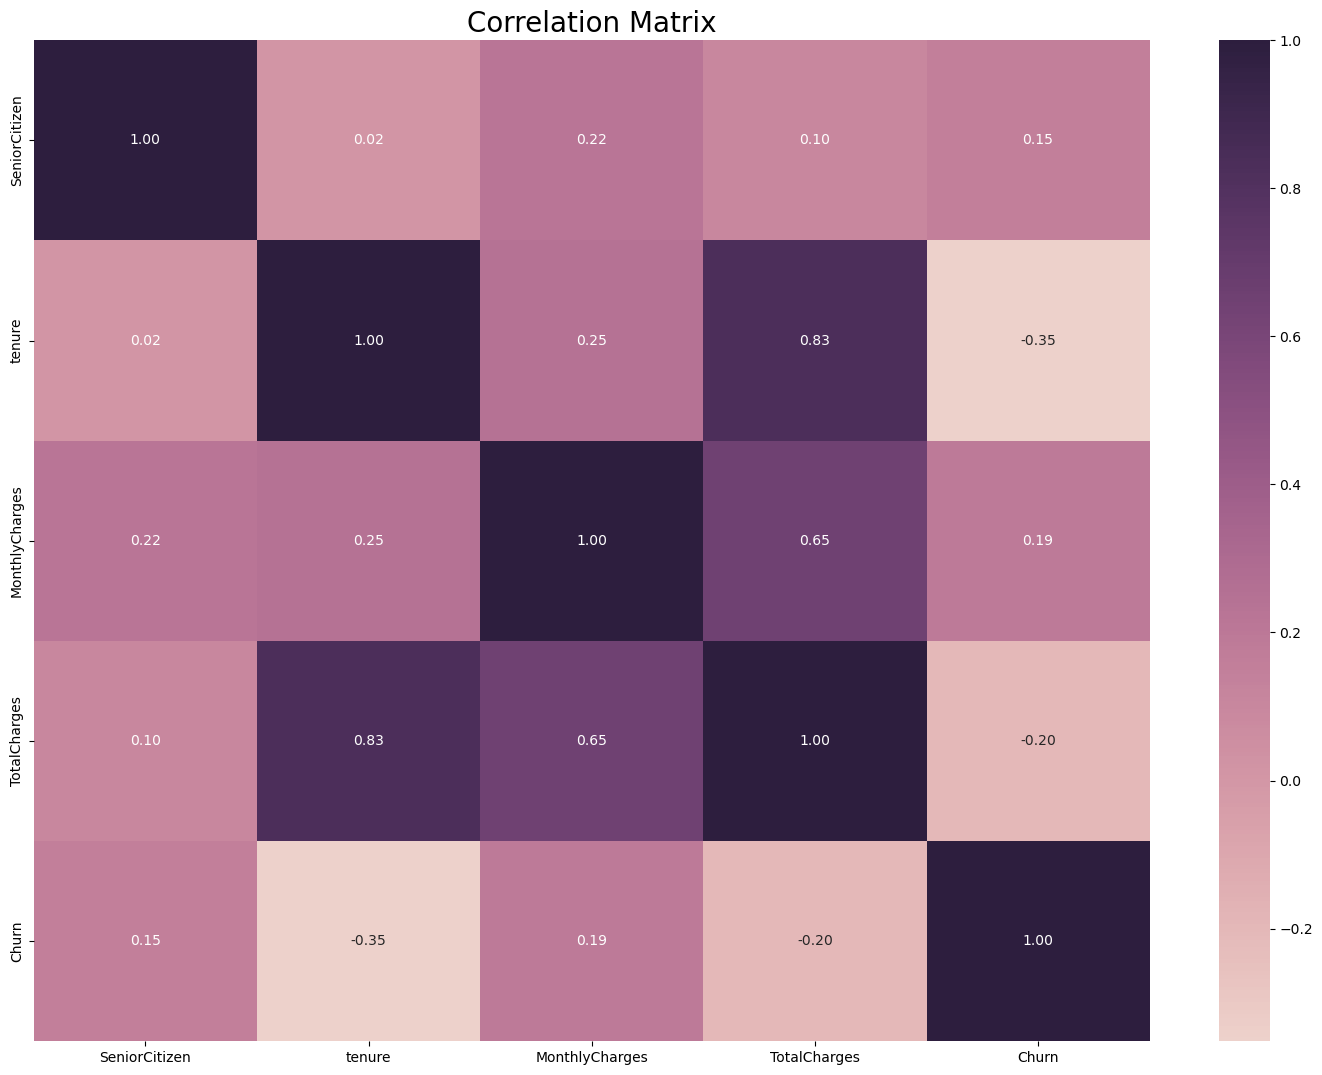

In [27]:
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", ax=ax, cmap=sns.cubehelix_palette(as_cmap=True))
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

In [28]:
df.corrwith(df["Churn"]).sort_values(ascending=False)

Churn             1.000
MonthlyCharges    0.193
SeniorCitizen     0.151
TotalCharges     -0.199
tenure           -0.352
dtype: float64

In [29]:
# Eksik Değerler
na_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
print(na_columns)

['TotalCharges']


In [30]:
n_miss = df[na_columns].isnull().sum().sort_values(ascending=False)
n_miss

TotalCharges    11
dtype: int64

In [31]:
ratio = (df[na_columns].isnull().sum() / df.shape[0] * 100).sort_values(ascending=False)


missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
print(missing_df)

              n_miss  ratio
TotalCharges      11  0.160


In [32]:
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)

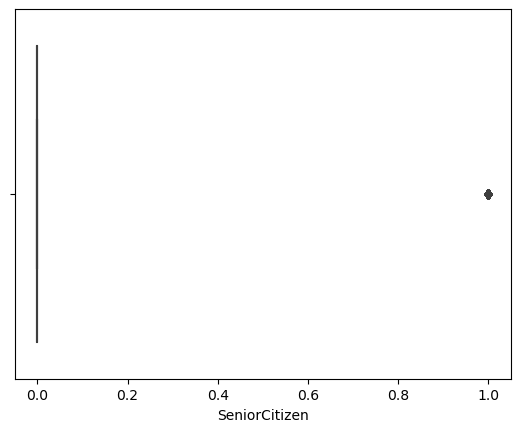

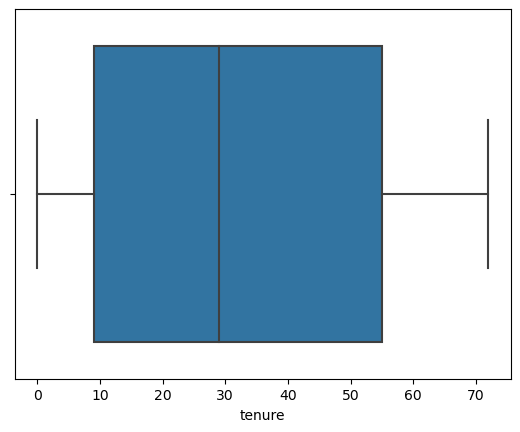

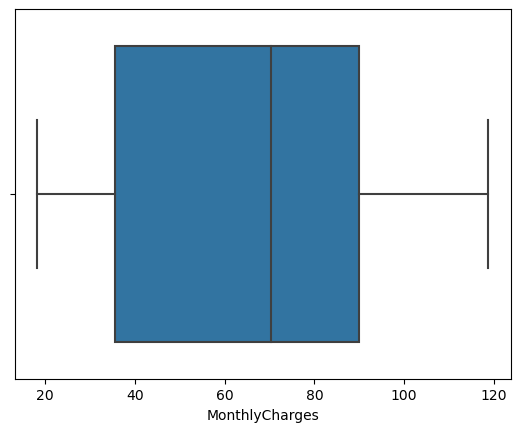

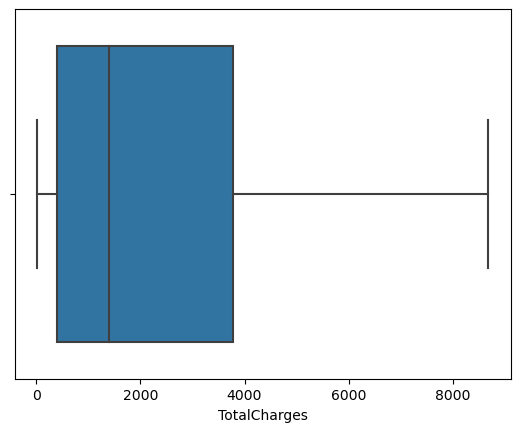

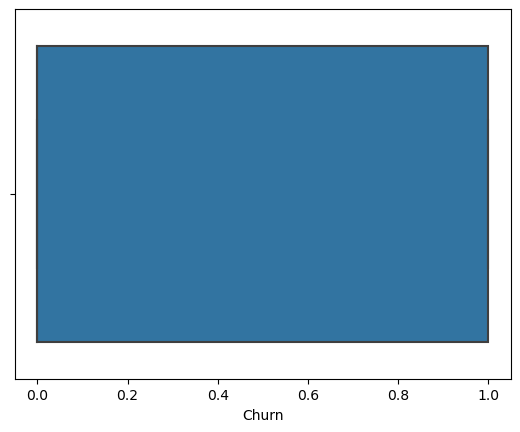

In [33]:
for col in num_cols:
    sns.boxplot(x=df[col])
    plt.show()
    
# Aykırı değer gözlenmiyor.

In [34]:
dff = df.copy()
cat_cols = [col for col in cat_cols if col not in ["Churn"]]

In [35]:
df[cat_cols].head()

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
0,Female,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check
1,Male,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check
2,Male,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check
3,Male,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic)
4,Female,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check


In [36]:
# Encoding
dff = pd.get_dummies(dff, columns=cat_cols, drop_first=True)

In [37]:
dff.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.850,29.850,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0
1,0,34,56.950,1889.500,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
2,0,2,53.850,108.150,1,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
3,0,45,42.300,1840.750,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0
4,0,2,70.700,151.650,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0


In [38]:
y = dff["Churn"]
X = dff.drop(["Churn"], axis=1) #,"customerID"

In [39]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

In [40]:
catboost_model = CatBoostClassifier(verbose=False, random_state=12345).fit(X_train, y_train)

y_pred = catboost_model.predict(X_test)

In [41]:
print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 4)}")
print(f"Recall: {round(recall_score(y_pred,y_test),4)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 4)}")
print(f"F1: {round(f1_score(y_pred,y_test), 4)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 4)}")
print(classification_report(y_pred, y_test))

Accuracy: 0.7885
Recall: 0.6414
Precision: 0.5017
F1: 0.563
Auc: 0.7348
              precision    recall  f1-score   support

           0       0.90      0.83      0.86      1664
           1       0.50      0.64      0.56       449

    accuracy                           0.79      2113
   macro avg       0.70      0.73      0.71      2113
weighted avg       0.81      0.79      0.80      2113



In [42]:
# Tenure  değişkeninden yıllık kategorik değişken oluşturma
df.loc[(df["tenure"]>=0) & (df["tenure"]<=12),"NEW_TENURE_YEAR"] = "0-1 Year"
df.loc[(df["tenure"]>12) & (df["tenure"]<=24),"NEW_TENURE_YEAR"] = "1-2 Year"
df.loc[(df["tenure"]>24) & (df["tenure"]<=36),"NEW_TENURE_YEAR"] = "2-3 Year"
df.loc[(df["tenure"]>36) & (df["tenure"]<=48),"NEW_TENURE_YEAR"] = "3-4 Year"
df.loc[(df["tenure"]>48) & (df["tenure"]<=60),"NEW_TENURE_YEAR"] = "4-5 Year"
df.loc[(df["tenure"]>60) & (df["tenure"]<=72),"NEW_TENURE_YEAR"] = "5-6 Year"

In [43]:
# Kontratı 1 veya 2 yıllık müşterileri Engaged olarak belirtme
df["NEW_Engaged"] = df["Contract"].apply(lambda x: 1 if x in ["One year","Two year"] else 0)

In [44]:
# Herhangi bir destek, yedek veya koruma almayan kişiler
df["NEW_noProt"] = df.apply(lambda x: 1 if (x["OnlineBackup"] != "Yes") or (x["DeviceProtection"] != "Yes") or (x["TechSupport"] != "Yes") else 0, axis=1)

In [45]:
# Aylık sözleşmesi bulunan ve genç olan müşteriler
df["NEW_Young_Not_Engaged"] = df.apply(lambda x: 1 if (x["NEW_Engaged"] == 0) and (x["SeniorCitizen"] == 0) else 0, axis=1)

In [46]:
# Kişinin toplam aldığı servis sayısı
df['NEW_TotalServices'] = (df[['PhoneService', 'InternetService', 'OnlineSecurity',
                                       'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                       'StreamingTV', 'StreamingMovies']]== 'Yes').sum(axis=1)

In [47]:
# Herhangi bir streaming hizmeti alan kişiler
df["NEW_FLAG_ANY_STREAMING"] = df.apply(lambda x: 1 if (x["StreamingTV"] == "Yes") or (x["StreamingMovies"] == "Yes") else 0, axis=1)

In [48]:
# Kişi otomatik ödeme yapıyor mu?
df["NEW_FLAG_AutoPayment"] = df["PaymentMethod"].apply(lambda x: 1 if x in ["Bank transfer (automatic)","Credit card (automatic)"] else 0)

In [49]:
# ortalama aylık ödeme
df["NEW_AVG_Charges"] = df["TotalCharges"] / (df["tenure"] + 1)

In [50]:
# Güncel Fiyatın ortalama fiyata göre artışı
df["NEW_Increase"] = df["NEW_AVG_Charges"] / df["MonthlyCharges"]

In [51]:
# Servis başına ücret
df["NEW_AVG_Service_Fee"] = df["MonthlyCharges"] / (df['NEW_TotalServices'] + 1)

In [52]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,NEW_TENURE_YEAR,NEW_Engaged,NEW_noProt,NEW_Young_Not_Engaged,NEW_TotalServices,NEW_FLAG_ANY_STREAMING,NEW_FLAG_AutoPayment,NEW_AVG_Charges,NEW_Increase,NEW_AVG_Service_Fee
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.850,0,0-1 Year,0,1,1,1,0,0,14.925,0.500,14.925
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.500,0,2-3 Year,1,1,0,3,0,0,53.986,0.948,14.238
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.150,1,0-1 Year,0,1,1,3,0,0,36.050,0.669,13.463
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.750,0,3-4 Year,1,1,0,3,0,1,40.016,0.946,10.575
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.650,1,0-1 Year,0,1,1,1,0,0,50.550,0.715,35.350


In [53]:
df.shape

(7043, 30)

In [54]:
cat_cols = [col for col in df.columns if df[col].dtypes == "O"]
num_cols = [col for col in df.columns if df[col].dtypes != "O"]

In [55]:
cat_cols

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'NEW_TENURE_YEAR']

In [56]:
num_cols

['SeniorCitizen',
 'tenure',
 'MonthlyCharges',
 'TotalCharges',
 'Churn',
 'NEW_Engaged',
 'NEW_noProt',
 'NEW_Young_Not_Engaged',
 'NEW_TotalServices',
 'NEW_FLAG_ANY_STREAMING',
 'NEW_FLAG_AutoPayment',
 'NEW_AVG_Charges',
 'NEW_Increase',
 'NEW_AVG_Service_Fee']

In [57]:
binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]
binary_cols

['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']

In [58]:
labelencoder = LabelEncoder()

In [59]:
for col in binary_cols:
    labelencoder = LabelEncoder()
    df[col] = labelencoder.fit_transform(df[col])

In [60]:
cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["Churn", "NEW_TotalServices"]]
cat_cols

['MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaymentMethod',
 'NEW_TENURE_YEAR']

In [61]:
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

In [62]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,NEW_Engaged,NEW_noProt,NEW_Young_Not_Engaged,NEW_TotalServices,NEW_FLAG_ANY_STREAMING,NEW_FLAG_AutoPayment,NEW_AVG_Charges,NEW_Increase,NEW_AVG_Service_Fee,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,NEW_TENURE_YEAR_1-2 Year,NEW_TENURE_YEAR_2-3 Year,NEW_TENURE_YEAR_3-4 Year,NEW_TENURE_YEAR_4-5 Year,NEW_TENURE_YEAR_5-6 Year
0,0,0,1,0,1,0,1,29.850,29.850,0,0,1,1,1,0,0,14.925,0.500,14.925,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,1,0,0,0,34,1,0,56.950,1889.500,0,1,1,0,3,0,0,53.986,0.948,14.238,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0
2,1,0,0,0,2,1,1,53.850,108.150,1,0,1,1,3,0,0,36.050,0.669,13.463,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,1,0,0,0,45,0,0,42.300,1840.750,0,1,1,0,3,0,1,40.016,0.946,10.575,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
4,0,0,0,0,2,1,1,70.700,151.650,1,0,1,1,1,0,0,50.550,0.715,35.350,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [63]:
# Eksik Değerler
na_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
print(na_columns)

[]


In [64]:
##################################
# AYKIRI DEĞER ANALİZİ 
##################################

def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=0.05, q3=0.95)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


In [65]:
# Aykırı Değer Analizi ve Baskılama İşlemi
for col in num_cols:
    print(col, check_outlier(df, col))
    if check_outlier(df, col):
        replace_with_thresholds(df, col)

SeniorCitizen False
tenure False
MonthlyCharges False
TotalCharges False
Churn False
NEW_Engaged False
NEW_noProt False
NEW_Young_Not_Engaged False
NEW_TotalServices False
NEW_FLAG_ANY_STREAMING False
NEW_FLAG_AutoPayment False
NEW_AVG_Charges True
NEW_Increase True
NEW_AVG_Service_Fee False


In [66]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,NEW_Engaged,NEW_noProt,NEW_Young_Not_Engaged,NEW_TotalServices,NEW_FLAG_ANY_STREAMING,NEW_FLAG_AutoPayment,NEW_AVG_Charges,NEW_Increase,NEW_AVG_Service_Fee,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,NEW_TENURE_YEAR_1-2 Year,NEW_TENURE_YEAR_2-3 Year,NEW_TENURE_YEAR_3-4 Year,NEW_TENURE_YEAR_4-5 Year,NEW_TENURE_YEAR_5-6 Year
0,0,0,1,0,1,0,1,29.850,29.850,0,0,1,1,1,0,0,14.925,0.500,14.925,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,1,0,0,0,34,1,0,56.950,1889.500,0,1,1,0,3,0,0,53.986,0.948,14.238,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0
2,1,0,0,0,2,1,1,53.850,108.150,1,0,1,1,3,0,0,36.050,0.669,13.463,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,1,0,0,0,45,0,0,42.300,1840.750,0,1,1,0,3,0,1,40.016,0.946,10.575,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
4,0,0,0,0,2,1,1,70.700,151.650,1,0,1,1,1,0,0,50.550,0.715,35.350,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [67]:
dff = df.copy()
dff.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,NEW_Engaged,NEW_noProt,NEW_Young_Not_Engaged,NEW_TotalServices,NEW_FLAG_ANY_STREAMING,NEW_FLAG_AutoPayment,NEW_AVG_Charges,NEW_Increase,NEW_AVG_Service_Fee,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,NEW_TENURE_YEAR_1-2 Year,NEW_TENURE_YEAR_2-3 Year,NEW_TENURE_YEAR_3-4 Year,NEW_TENURE_YEAR_4-5 Year,NEW_TENURE_YEAR_5-6 Year
0,0,0,1,0,1,0,1,29.850,29.850,0,0,1,1,1,0,0,14.925,0.500,14.925,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,1,0,0,0,34,1,0,56.950,1889.500,0,1,1,0,3,0,0,53.986,0.948,14.238,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0
2,1,0,0,0,2,1,1,53.850,108.150,1,0,1,1,3,0,0,36.050,0.669,13.463,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,1,0,0,0,45,0,0,42.300,1840.750,0,1,1,0,3,0,1,40.016,0.946,10.575,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
4,0,0,0,0,2,1,1,70.700,151.650,1,0,1,1,1,0,0,50.550,0.715,35.350,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [68]:
y = dff["Churn"]
X = dff.drop(["Churn"], axis=1)

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

### catboost_model

In [70]:
catboost_model = CatBoostClassifier(verbose=False, random_state=12345).fit(X_train, y_train)
y_pred = catboost_model.predict(X_test)

In [71]:
print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),2)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")
print(classification_report(y_pred, y_test))

Accuracy: 0.79
Recall: 0.65
Precision: 0.49
F1: 0.56
Auc: 0.74
              precision    recall  f1-score   support

           0       0.90      0.83      0.86      1678
           1       0.49      0.65      0.56       435

    accuracy                           0.79      2113
   macro avg       0.69      0.74      0.71      2113
weighted avg       0.82      0.79      0.80      2113



In [72]:
def plot_importance(model, features, num=len(X)):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()

In [73]:
catboost_model.feature_importances_

array([2.59234336, 1.68657977, 1.28753148, 1.34458644, 8.75716069,
       0.68691453, 3.68019284, 7.89369974, 8.44028694, 5.36973485,
       0.06736823, 1.11957665, 1.54832158, 0.76263685, 1.05083259,
       6.75854878, 9.74369116, 9.11614966, 0.96798758, 1.76312051,
       2.63221838, 0.29912831, 0.42346259, 0.97099449, 0.18333594,
       1.12864829, 0.0819362 , 1.57104025, 0.22681498, 1.65575253,
       0.25613665, 1.13250419, 0.37615264, 1.02906954, 1.32960808,
       3.79514324, 1.22660867, 1.56934476, 1.13382786, 0.35973184,
       1.28415238, 0.825232  , 0.46959523, 1.40229672])

In [74]:
feature_imp = pd.DataFrame({'Value': catboost_model.feature_importances_, 'Feature': X.columns})
feature_imp.sort_values(by="Value",ascending=False)

,Value,Feature
16,9.744,NEW_Increase
17,9.116,NEW_AVG_Service_Fee
4,8.757,tenure
8,8.440,TotalCharges
7,7.894,MonthlyCharges
15,6.759,NEW_AVG_Charges
9,5.370,NEW_Engaged
35,3.795,Contract_Two year
6,3.680,PaperlessBilling
20,2.632,InternetService_Fiber optic


### Random Forests 

In [75]:
rf_model = RandomForestClassifier(random_state=17).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [76]:
print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),2)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")
print(classification_report(y_pred, y_test))

Accuracy: 0.78
Recall: 0.62
Precision: 0.48
F1: 0.54
Auc: 0.72
              precision    recall  f1-score   support

           0       0.89      0.82      0.85      1669
           1       0.48      0.62      0.54       444

    accuracy                           0.78      2113
   macro avg       0.69      0.72      0.70      2113
weighted avg       0.80      0.78      0.79      2113



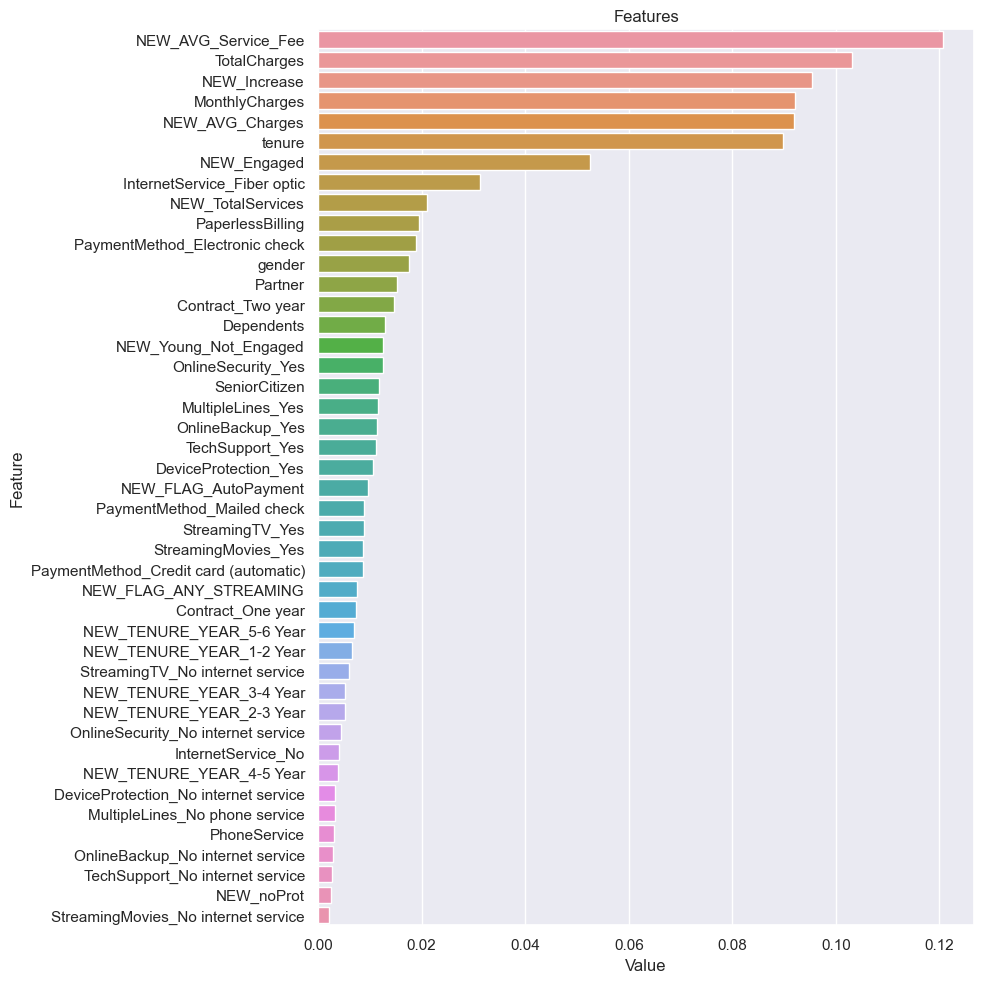

In [77]:
plot_importance(rf_model, X)

### CART

In [78]:
cart_model = DecisionTreeClassifier(random_state=17).fit(X_train, y_train)
y_pred = cart_model.predict(X_test)

In [79]:
print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),2)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")
print(classification_report(y_pred, y_test))

Accuracy: 0.72
Recall: 0.48
Precision: 0.5
F1: 0.49
Auc: 0.65
              precision    recall  f1-score   support

           0       0.80      0.81      0.80      1512
           1       0.50      0.48      0.49       601

    accuracy                           0.72      2113
   macro avg       0.65      0.65      0.65      2113
weighted avg       0.71      0.72      0.71      2113



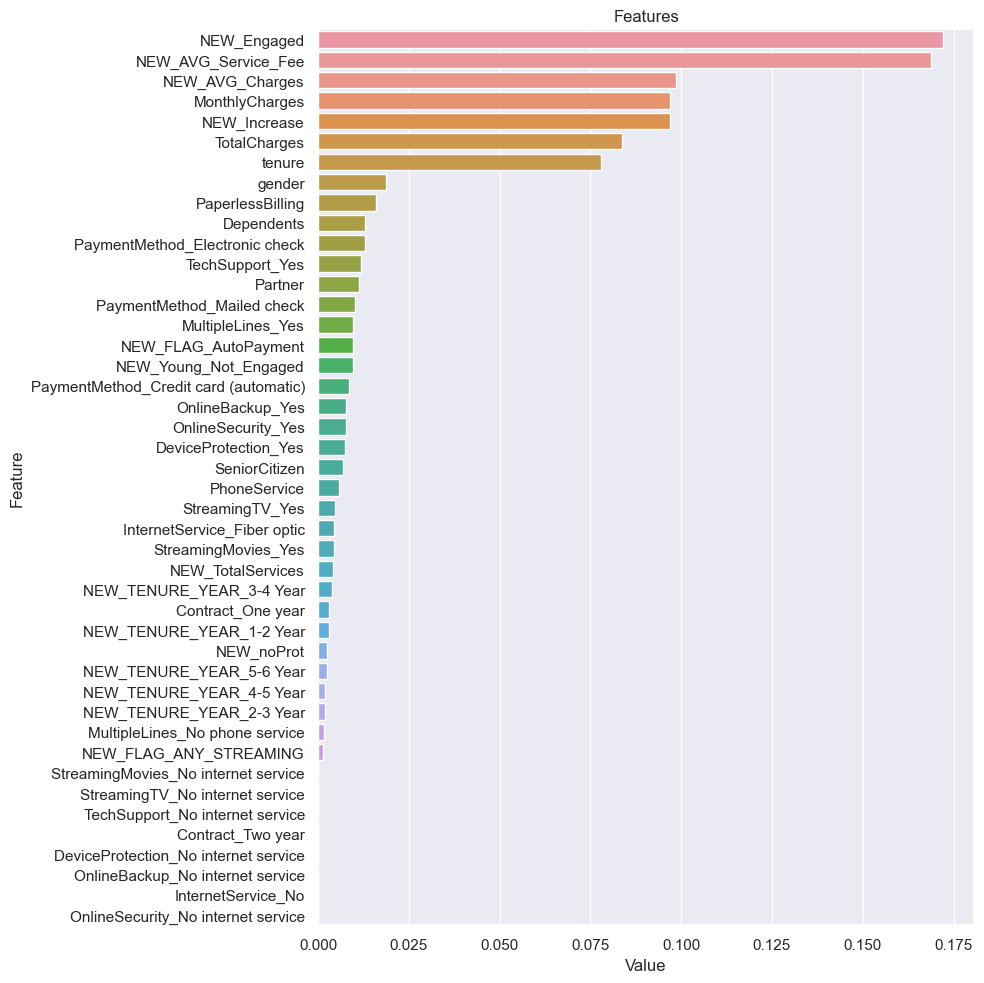

In [80]:
plot_importance(cart_model, X)

###  Hyperparameter optimization

### Random Forests HPO

In [81]:
rf_model = RandomForestClassifier(random_state=17)

rf_params = {"max_depth": [8, 10, None],
             "max_features": [15, "auto"],
             "min_samples_split": [2, 5],
             "n_estimators": [100]} 


In [82]:
rf_best_grid = GridSearchCV(rf_model, rf_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [83]:
rf_best_grid.best_params_

{'max_depth': 8,
 'max_features': 'auto',
 'min_samples_split': 5,
 'n_estimators': 100}

In [84]:
rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=17).fit(X, y)

In [85]:
y_pred = rf_final.predict(X_test)

In [86]:
print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),2)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")
print(classification_report(y_pred, y_test))

Accuracy: 0.83
Recall: 0.74
Precision: 0.56
F1: 0.63
Auc: 0.79
              precision    recall  f1-score   support

           0       0.93      0.85      0.89      1682
           1       0.56      0.74      0.63       431

    accuracy                           0.83      2113
   macro avg       0.74      0.79      0.76      2113
weighted avg       0.85      0.83      0.83      2113

